In [1]:
import os
import math
import csv
import pickle
import statistics
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from random import sample,choices,choice,uniform, randint,shuffle
from DSSCircuit_Interface import *

In [2]:
FolderName=os.path.dirname(os.path.realpath("__file__"))
G_original = nx.read_gml(""+ FolderName+ r"\34busEx.gml")
nodes=list(G_original.nodes())
edges=list(G_original.edges())

In [3]:
DSSfile=r""+ FolderName+ "\ieee34Mod2.dss" 
d_obj= DSS(DSSfile) #create a circuit object
d_obj.compile_ckt_dss() #compiling the circuit
d_obj.dssText.command = "Set Maxiterations=200" 
d_obj.dssText.command = "Set maxcontroliter=200"
d_obj.AllowForms=False 
# d_obj.dssText.command = "Set controlmode=OFF"

In [4]:
#Creating Array of Loadshapes
LoadShape = []
input_file = 'LoadShape1.xlsx'
sheet_name = 'LoadShape1'  # Change to the sheet you want to split
df = pd.read_excel(input_file, sheet_name=sheet_name)

# Number of parts to split the file into
num_files = 365  

# Calculate the number of rows per file
rows_per_file = math.ceil(len(df) / num_files)

# Split and save to new Excel files
for i in range(num_files):
    start_row = i * rows_per_file
    end_row = min((i + 1) * rows_per_file, len(df))
    
    # Create a new DataFrame for each chunk
    chunk_df = df[start_row:end_row]
    
    # Convert dataframe to list
    loadshape = []
    value = chunk_df.values.tolist()
    for x in range(len(value)):
        data = float(value[x][0])
        loadshape.append(data)    
    LoadShape.append(loadshape)

In [5]:
#Loading PV information
PVs = [{'no':1, 'bus':'890', 'numphase':3, 'phaseconn':'.1.2.3', 'size':250, 'kV':4.16, 'KVA':250},
        {'no':2, 'bus':'806', 'numphase':3, 'phaseconn':'.1.2.3', 'size':250, 'kV':4.16, 'KVA':250},
        {'no':3, 'bus':'816', 'numphase':3, 'phaseconn':'.1.2.3', 'size':250, 'kV':4.16, 'KVA':250}]

# Obtaining list of buses connected to PVSystems
PVbuses = []
for pv in range(len(PVs)):
    PVbuses.append(PVs[pv]['bus'])

In [6]:
#Defining Temperature values
temp =[25, 25, 25, 25, 25, 25, 25, 25, 40, 50, 60, 65, 65, 65, 57, 50, 35,  30,  25, 25, 25, 25, 25, 25]
#Time = range(0,24)
#plt.plot(Time, temp, "-o")

In [16]:
nbua = randint(1,3)
nbua

3

In [7]:
#Adding PVs to DSS Circuit
d_obj.dssText.command='redirect PVSystem.dss'
# d_obj.dssText.command = f"New LoadShape.MyIrrad0 npts=288 minterval=5 mult={Irradiance[0]} Action=Normalize"
d_obj.dssText.command = f"New Tshape.MyTemp npts=24 interval=1 temp={temp}"
for pv in range(len(PVs)):
        d_obj.dssText.command=f"New PVSystem.PV{PVs[pv]['no']} bus1={PVs[pv]['bus'] + PVs[pv]['phaseconn']} phases={str(PVs[pv]['numphase'])} kv={str(PVs[pv]['kV'])} kVA={str(PVs[pv]['KVA'])} pf=0.8 Pmpp={str(PVs[pv]['size'])} %cutin=0.1 %cutout=0.1 effcurve=Myeff P-TCurve=MyPvsT Daily=PVLoadShape2 TDaily=MyTemp"

In [9]:
#Generating PF Attacks
buses=list(G_original.nodes())
edge_dict=list(G_original.edges(data=True)) 
Prelim_Dataset = []
Nsc_A = 1 #No. of Anomalous scenarios
count = 0
for i in range(Nsc_A):
#     d_obj.dssText.command = f"New LoadShape.MyIrrad{i} npts=288 minterval=5 mult={Irradiance[i]} Action=Normalize"
    d_obj.dssText.command = f"New LoadShape.Lshape{i} npts=24 interval=1 mult={LoadShape[i]}"
    d_obj.dssText.command = f"Batchedit Load..* Daily=Lshape{i}"
    d_obj.dssText.command = "Set mode=Daily"
    d_obj.dssText.command = "Set stepsize=5m"
    d_obj.dssText.command = "Set number=1"
    dsstime = 0
    TimeSeries_Data = []
    anom_pv = randint(0,2) #random sampling of PVs with replacement
    pf = uniform(-0.6,0.6)
    for pv in range(len(PVs)):
        if anom_pv == pv:
            d_obj.dssText.command = f"Edit PVSystem.PV{PVs[pv]['no']} bus1={PVs[pv]['bus'] + PVs[pv]['phaseconn']} phases={str(PVs[pv]['numphase'])} kv={str(PVs[pv]['kV'])} kVA={str(PVs[pv]['KVA'])} pf={pf} Pmpp={str(PVs[pv]['size'])} %cutin=0.1 %cutout=0.1 effcurve=Myeff P-TCurve=MyPvsT Daily=PVLoadShape2 TDaily=MyTemp"
        else:
            d_obj.dssText.command = f"Edit PVSystem.PV{PVs[pv]['no']} bus1={PVs[pv]['bus'] + PVs[pv]['phaseconn']} phases={str(PVs[pv]['numphase'])} kv={str(PVs[pv]['kV'])} kVA={str(PVs[pv]['KVA'])} pf=0.8 Pmpp={str(PVs[pv]['size'])} %cutin=0.1 %cutout=0.1 effcurve=Myeff P-TCurve=MyPvsT Daily=PVLoadShape2 TDaily=MyTemp"
    while dsstime<24: 
        d_obj.dssText.Command = 'Solve'
        dsstime = d_obj.dssSolution.dblHour
        Branchflow_Data = []
        Bus_Data = []
        for b in buses:
            d_obj.dssCircuit.SetActiveBus(b) #Setting Active Bus
            node_num=np.array(d_obj.dssBus.Nodes)
            bus_size = node_num.size
            V=np.array(d_obj.dssBus.puVmagAngle)
            ctidx = 2 * np.array(range(0, min(int(V.size/ 2), 3))) 
            if b in PVbuses:
                j= d_obj.dssCircuit.PVSystems.First
                while j>0:
                    elemName = d_obj.dssCircuit.ActiveCktElement.Name
                    busconnectn = d_obj.dssCircuit.ActiveCktElement.BusNames[0].split('.')[0]
                    if b == busconnectn:
                        S=np.array(d_obj.dssCircuit.ActiveCktElement.Powers)
                        P_Gen = S[ctidx]
                        break
                    j=d_obj.dssCircuit.PVSystems.Next
            else:
                P_Gen=np.empty((bus_size,)) * np.nan
            Bus_Data.append({'Bus Name':b, 'Voltage Magnitude':V[ctidx], 'Power Generated':P_Gen})
        for e in G_original.edges(data=True):
            name = e[2]['device'] + '.' +e[2]['label']
            d_obj.dssCircuit.SetActiveElement(name) #Setting Active Edge Element
            c=np.array(d_obj.dssCktElement.CurrentsMagAng)
            ctidx = 2 * np.array(range(0, min(int(c.size/ 4), 3)))
            I_mag = c[ctidx]
            I_avg=np.average(I_mag)
            Branchflow_Data.append({'Branch Name':name,'BranchFlow':I_avg}) 
        TimeSeries_Data.append({'Time Step':dsstime, 'Bus_Info': Bus_Data, 'Branchflow':Branchflow_Data})
    count = count + 1
    print(count)
    Scenario_Info={'Scenario_Number':count, 'Anomalous': 'Yes', 'Attack_Type':'PF', 'Affected_PV':'PV '+str(anom_pv+1), 'Power Factor':pf, 'TimeSeries_Data':TimeSeries_Data}
    Prelim_Dataset.append(Scenario_Info)

1


In [9]:
Prelim_Dataset[0]

{'Scenario_Number': 1,
 'Anomalous': 'Yes',
 'Attack_Type': 'PF',
 'Affected_PV': 'PV 1',
 'Power Factor': 0.41185246837192524,
 'TimeSeries_Data': [{'Time Step': 0.08333333333333333,
   'Bus_Info': [{'Bus Name': 'sourcebus',
     'Voltage Magnitude': array([1.04999995, 1.05000046, 1.05000045]),
     'Power Generated': array([nan, nan, nan])},
    {'Bus Name': '800',
     'Voltage Magnitude': array([1.04999976, 1.04999984, 1.05000041]),
     'Power Generated': array([nan, nan, nan])},
    {'Bus Name': '802',
     'Voltage Magnitude': array([1.04900061, 1.04944326, 1.04946984]),
     'Power Generated': array([nan, nan, nan])},
    {'Bus Name': 'mid806',
     'Voltage Magnitude': array([1.04866548, 1.04925665, 1.04929183]),
     'Power Generated': array([nan, nan, nan])},
    {'Bus Name': '806',
     'Voltage Magnitude': array([1.0483263 , 1.0490955 , 1.04912873]),
     'Power Generated': array([ 0., -0.,  0.])},
    {'Bus Name': '808',
     'Voltage Magnitude': array([1.0356394 , 1.0430

In [13]:
len(buses)

56

In [10]:
for i in range(len(Prelim_Dataset)):
    print(Prelim_Dataset[i]['Affected_PV'])
    

PV 3


In [10]:
#Restructuring Dataset into multi-dimensional array
Dataset = []
Ttot = 288
dim_x = Ttot
dim_Vy = len(buses)
dim_Cy = len(edges)
for d in range (len(Prelim_Dataset)):
    Varray_3d = np.zeros((dim_x,dim_Vy,3))
    Varray_2d = np.zeros((dim_Vy,3))
    Carray_3d = np.zeros((dim_x,dim_Cy,1))
    Carray_2d = np.zeros((dim_Cy,1))
    Parray_3d = np.zeros((dim_x,dim_Vy,3))
    Parray_2d = np.zeros((dim_Vy,3))
    for t in range(Ttot):
        for v in range(len(buses)):
            voltage_magnitude = Prelim_Dataset[d]['TimeSeries_Data'][t]['Bus_Info'][v]['Voltage Magnitude']
            power_generated = Prelim_Dataset[d]['TimeSeries_Data'][t]['Bus_Info'][v]['Power Generated']
            # Ensure both have length 3
            if np.isnan(power_generated[0]):
                mode = 'edge'
            else:
                mode = 'constant'
            Varray_2d[v, :] = np.pad(voltage_magnitude, (0, max(0, 3 - len(voltage_magnitude))), 'constant')[:3]
            Parray_2d[v, :] = -np.pad(power_generated, (0, max(0, 3 - len(power_generated))), mode)[:3]
        Varray_3d[t, :, :] = Varray_2d
        Parray_3d[t, :, :] = Parray_2d
        for c in range(len(edges)):
            Carray_2d[c, :] = Prelim_Dataset[d]['TimeSeries_Data'][t]['Branchflow'][c]['BranchFlow']
        Carray_3d[t, :, :] = Carray_2d
    Scenario_Data = {'Anomalous':Prelim_Dataset[d]['Anomalous'],'Attack_Type':'PF','Targeted_PV':Prelim_Dataset[d]['Affected_PV'],'TimeSeries_PowerGen':Parray_3d, 'TimeSeries_Voltage':Varray_3d, 'BranchFlow':Carray_3d}
    Dataset.append(Scenario_Data)

In [11]:
#Loading .pkl file
a = open('PVanomalydatasetPF.pkl', 'wb')
pickle.dump(Dataset,a)
a.close()

In [12]:
Dataset[0]

{'Scenario_Number': 0,
 'Anomalous': 'Yes',
 'Targeted_PV': 'Nil',
 'TimeSeries_PowerGen': array([[[        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         ...,
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [-0.        ,  0.        , -0.        ]],
 
        [[        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         ...,
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [-0.        ,  0.        , -0.        ]],
 
        [[        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         ...,
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [-0

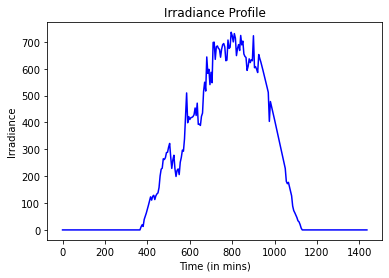

In [24]:
#Plotting NSRDB Irradiance Profiles
Time = list(range(0,1440,5))
I = []
# P2 = []
# P3 = []
for t in range(len(Time)):
    irr = Irradiance[101][t]
    I.append(irr)

#Creating graph plot of power profile at PV
plt.plot(Time, I, "-b")

# Add title and axis labels
plt.title("Irradiance Profile")
plt.xlabel("Time (in mins)")
plt.ylabel("Irradiance")
# plt.legend()

#Displaying the plot
plt.show()

In [8]:
#Plotting PG at a bus after FDIA
Time = list(range(0,1440,5))
P1 = []
# P2 = []
# P3 = []
for t in range(len(Time)):
    p1 = -Prelim_Dataset[0]['TimeSeries_Data'][t]['Bus_Info'][55]['Power Generated']
    P1.append(p1)

#Creating graph plot of power profile at PV
plt.plot(Time, P1, "-b")
# plt.plot(Time, P2, "-r", label="Phase 2")
# plt.plot(Time, P3, "-k", label="Phase 3")

# Add title and axis labels
plt.title("Power Generated at PV after FDIA")
plt.xlabel("Time (in mins)")
plt.ylabel("Power (in kW)")
# plt.legend()

#Displaying the plot
plt.show()

NameError: name 'Prelim_Dataset' is not defined

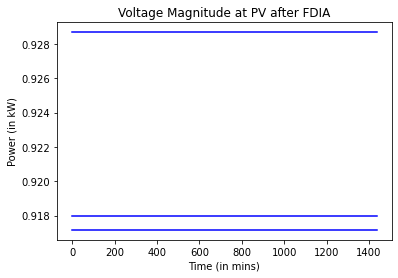

In [12]:
#Plotting Voltage at a bus after FDIA
Time = list(range(0,1440,5))
P1 = []
P2 = []
P3 = []
for t in range(len(Time)):
    p = Prelim_Dataset[0]['TimeSeries_Data'][t]['Bus_Info'][55]['Voltage Magnitude']
    P1.append(p)

#Creating graph plot of power profile at PV
plt.plot(Time, P1, "-b", label="Phase 1")
# plt.plot(Time, P2, "-r", label="Phase 2")
# plt.plot(Time, P3, "-k", label="Phase 3")

# Add title and axis labels
plt.title("Voltage Magnitude at PV after FDIA")
plt.xlabel("Time (in mins)")
plt.ylabel("Power (in kW)")
# plt.legend()

#Displaying the plot
plt.show()

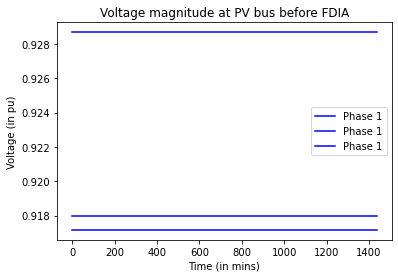

In [13]:
#Plotting Voltage at a bus before FDIA
Time = list(range(0,1440,5))
P1 = []
# P2 = []
# P3 = []
for t in range(len(Time)):
    p = Prelim_Dataset[0]['TimeSeries_Data'][t]['Bus_Info'][55]['Voltage Magnitude']
    P1.append(p)

#Creating graph plot of power profile at PV
plt.plot(Time, P1, "-b", label="Phase 1")
# plt.plot(Time, P2, "-r", label="Phase 2")
# plt.plot(Time, P3, "-k", label="Phase 3")

# Add title and axis labels
plt.title("Voltage magnitude at PV bus before FDIA")
plt.xlabel("Time (in mins)")
plt.ylabel("Voltage (in pu)")
plt.legend()

#Displaying the plot
plt.show()

In [12]:
buses[37]

'844'

In [11]:
for i in range(len(buses)):
    if buses[i]=='56':
        break
        
print(i)

55


In [16]:
# d_obj.dssPVSystems.Next
# d_obj.dssPVSystems.Name

d_obj.dssCircuit.Loadshapes.First
d_obj.dssCircuit.Loadshapes.Next
d_obj.dssCircuit.Loadshapes.Next
d_obj.dssCircuit.Loadshapes.Name

'loadshape_multload'

In [7]:
#Loading Original Loadshape File
LoadShape = []
with open('Loadshape_multload.csv') as csvfile:
    data = list(csv.reader(csvfile))

for x in range(len(data)):
    value = float(data[x][1])
    LoadShape.append(value)
    
#Creating Array of Loadshapes
Loadshapes = []
Loadshapes.append(LoadShape)
std = statistics.stdev(LoadShape)
mean = statistics.mean(LoadShape)
length = len(LoadShape)
Nsc_N = 1
for i in range(Nsc_N):
    noise = np.random.normal(mean,std,length)
    Loadshapes.append(list(noise))

In [9]:
#Creating New Array of Loadshapes
Loadshapes2 = []
Loadshapes.append(LoadShape)
std = statistics.stdev(LoadShape)
mean = statistics.mean(LoadShape)
length = len(LoadShape)
for i in range(N_PfA):
    noise = np.random.normal(mean,std,length)
    Loadshapes2.append(list(noise))

In [7]:
#Generating Anomalous Scenarios
N_PfA = 2
for j in range(N_PfA):
    Normal_Data = []
    TimeSeries_Data = []
    dsstime = 0
    d_obj.dssText.command = "Set mode=Daily"
    d_obj.dssText.command = "Set stepsize=5m"
    d_obj.dssText.command = "Set number=1"
    d_obj.dssText.command='redirect PVSystem.dss'
    anom_pv = randint(0,2)
    pf = uniform(-1.0,0.6)
    d_obj.dssText.command=('Edit PVSystem.PV' + str(PVs[anom_pv]['no']) + ' bus1=' + PVs[anom_pv]['bus'] + PVs[anom_pv]['phaseconn'] + ' phases=' + str(PVs[anom_pv]['numphase']) + ' kv=' + str(PVs[anom_pv]['kV']) + ' kVA=' + str(PVs[anom_pv]['KVA']) +
                               ' pf=' + str(pf) + ' Pmpp=' +str(PVs[anom_pv]['size']) + ' irrad=0.8 temperature=25 conn=del  effcurve=Myeff  P-TCurve=MyPvsT Daily=PVLoadShape2  TDaily=MyTemp')
    for pv in range(len(PVs)):
        if pv!=anom_pv:
            d_obj.dssText.command=('Edit PVSystem.PV' + str(PVs[pv]['no']) + ' bus1=' + PVs[pv]['bus'] + PVs[pv]['phaseconn'] + ' phases=' + str(PVs[pv]['numphase']) + ' kv=' + str(PVs[pv]['kV']) + ' kVA=' + str(PVs[pv]['KVA']) +
                                   ' pf=1' + ' Pmpp=' +str(PVs[pv]['size']) + ' %cutin=0.1 %cutout=0.1 effcurve=Myeff  P-TCurve=MyPvsT Daily=PVLoadShape2  TDaily=MyTemp')
    while dsstime<24: 
        d_obj.dssText.Command = 'Solve'
        dsstime = d_obj.dssSolution.dblHour
        Branchflow_Data = []
        Bus_Data = []
        for b in buses:
            d_obj.dssCircuit.SetActiveBus(b) #Setting Active Bus
            node_num=np.array(d_obj.dssBus.Nodes)
            bus_size = node_num.size
            V=np.array(d_obj.dssBus.puVmagAngle)
            ctidx = 2 * np.array(range(0, min(int(V.size/ 2), 3)))
            if b in PVbuses:
                i= d_obj.dssCircuit.PVSystems.First
                while i>0:
                    elemName = d_obj.dssCircuit.ActiveCktElement.Name
                    busconnectn = d_obj.dssCircuit.ActiveCktElement.BusNames[0].split('.')[0]
                    if b == busconnectn:
                        S=np.array(d_obj.dssCircuit.ActiveCktElement.Powers)
                        P_Gen = S[ctidx]
                        break
                    i=d_obj.dssCircuit.PVSystems.Next
            else:
                P_Gen=np.empty((bus_size,)) * np.nan
            Bus_Data.append({'Bus Name':b, 'Voltage Magnitude':V[ctidx], 'Power Generated':P_Gen})
        for e in G_original.edges(data=True):
            name = e[2]['device'] + '.' +e[2]['label']
            d_obj.dssCircuit.SetActiveElement(name) #Setting Active Edge Element
            i=np.array(d_obj.dssCktElement.CurrentsMagAng)
            ctidx = 2 * np.array(range(0, min(int(i.size/ 4), 3)))
            I_mag = i[ctidx]
            I_avg=np.average(I_mag)
            Branchflow_Data.append({'Branch Name':name,'BranchFlow':I_avg}) 
        TimeSeries_Data.append({'Time Step':dsstime, 'Bus_Info': Bus_Data, 'Branchflow':Branchflow_Data})
    Scenario_Info={'Scenario_Number':count, 'Anomalous': 'Yes', 'Affected_PV':'PV '+str(anom_pv+1), 'Anomalous PF':pf, 'TimeSeries_Data':TimeSeries_Data}
    Prelim_Dataset.append(Scenario_Info)
    count = count + 1
    d_obj.dssCircuit.Loadshapes.Next